In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from matplotlib import pyplot
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition
from numpy.core.multiarray import ndarray
import math
import numpy as np
import matplotlib as mpl
import matplotlib.backends.backend_pdf
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.odr import Model
from xlrd import open_workbook
from scipy.optimize import curve_fit
from pandas import read_csv
import statistics
import scipy as scipy
from scipy import optimize
import matplotlib.ticker as ticker
#import lmfit
import scipy.constants as scpc
import random
#######################################################
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['font.size'] = 75
mpl.rcParams['font.family'] = 'Sans Serif'
mpl.rcParams['axes.labelsize'] = 36
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['xtick.major.size'] = 8
mpl.rcParams['xtick.minor.size'] = 5
mpl.rcParams['ytick.major.size'] = 8
mpl.rcParams['ytick.minor.size'] = 5
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['xtick.direction'] = "in"
mpl.rcParams['ytick.direction'] = "in"


In [3]:
datafiles=[
       "YmnSn_5K_240G_u",
    "YmnSn_10K_240G_u",
    "YmnSn_20K_240G_u",
    "YmnSn_30K_240G_u",
    "YmnSn_40K_240G_u",
    "YmnSn_60K_240G_u",
    "YmnSn_80K_240G_u",
    "YmnSn_100K_240Gb_u",
    "YmnSn_125K_240Gb_u",
    "YmnSn_150K_240Gb_u",
    "YmnSn_200K_240Gb_u",
    "YmnSn_250K_240Gb_u",
    "YmnSn_290K_240Gb_u"
          ]

### Dictionaries and Lists ###
dict_data={}
gfactors=[]
linewidths=[]
temps=[]

X1_angles=[290,255,260,270,245,230,285,285,270,275,270,280,265]

### Fit Functions ###

def dLorentzian(x, amp, cen, wid,disp):
        df = ((- amp * wid/(2*math.pi)* (x - cen))/(((x - cen)**2 + (wid/2)**2)**2))+disp
        return df
    
    ####### Beginning Loop through all datafiles, commands will be repeated for each upsweep and downsweep file ########
for i in range(len(datafiles)):
    
######### Parsing filename for temperature ##############################
    temp=datafiles[i][6:10]
    while temp[-1]!="K":
        temp=temp[0:len(temp)-1]
    temp=temp.replace("p", "." )
    temp2=float(temp[0:-1])
  

    
######## Parsing for header length ######################################
    file=open(datafiles[i]+".dat")
    data=file.readlines()
    for n, line in enumerate(data):
        array=line.split('\s+')
        if array[0][0:6]==">BEGIN":
            header_index=n
            #print(header_index)
            break
    file.close()
    
    ### Sorting ###
    data_u=np.array(pd.read_csv(datafiles[i]+".dat", sep='\s+',header=header_index))

    phi_1=X1_angles[i]
    
    B=data_u[:,0]
    B_field=0.99775*B + 0.00013*(B**2)
    X1=data_u[:,1]
    X2=data_u[:,2]
    X1_corrected = X1*np.cos(np.radians(phi_1))+X2*np.sin(np.radians(phi_1))
    
        ### Guess Values for Lorentzian ### 

    y0_val_max = (max(X1_corrected))
    y0_val_min = (min(X1_corrected))
    
    y0_index_max = np.where(X1_corrected == y0_val_max)[0]
    y0_index_max_refined = random.choice(y0_index_max)
    
    y0_index_min = np.where(X1_corrected == y0_val_min)[0]
    y0_index_min_refined = random.choice(y0_index_min)
    
    xmax = (B_field[y0_index_max_refined])
    xmin = (B_field[y0_index_min_refined])
    
    y0_val = (y0_val_max+y0_val_min)
    H0_val = ((xmax+xmin)/2)
    wid_val = abs(xmax-xmin)
    amp_val =2*math.pi*3**(1/2)*wid_val**2/9*y0_val_max
    disp_val = X1_corrected[0]
    
    
    ### Fitting Parameters ###

    dLparameters,_ = curve_fit(dLorentzian, B_field, X1_corrected, [amp_val, H0_val,wid_val,disp_val])
    
    x_line = np.arange(min(B_field), max(B_field), 0.000181)
    dy_line = dLorentzian(x_line, dLparameters[0], dLparameters[1], dLparameters[2],dLparameters[3])
    
    
    ### Extracting Fit Parameters ###

    g_factor = (6.62607 * 10**(-34) * 2.4 * 10**11)/(scpc.value('Bohr magneton') * dLparameters[1])
    linewidth = dLparameters[2]

### Loading Data into Dictionarires ###
    dict_data[datafiles[i]]=[B_field, #0
                             X1, #1
                             X2, #2
                             temp, #3
                             X1_corrected, #4
                             x_line, #5
                             dy_line, #6
                             g_factor, #7
                             linewidth, #8
                             phi_1, #9
                             dLparameters[1], #10
                             disp_val, #11
                             X1_corrected[0], #12
                            ]
          


    
    gfactors.append(g_factor)
    linewidths.append(linewidth)
    temps.append(temp2)

    


C:\Users\lovia\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


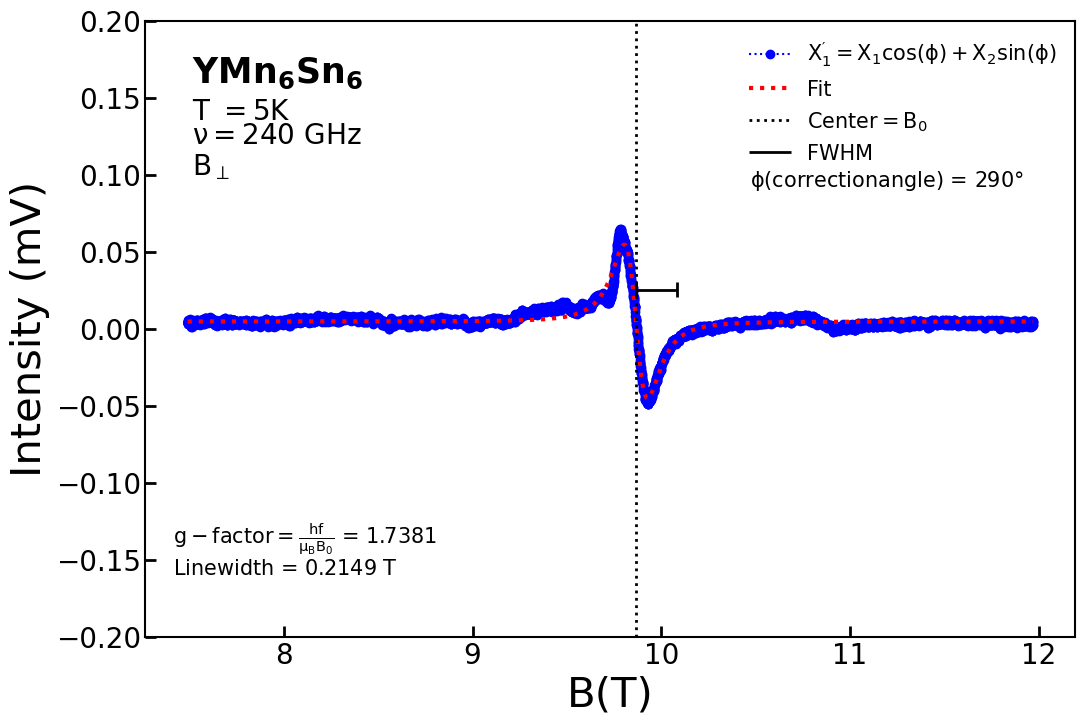

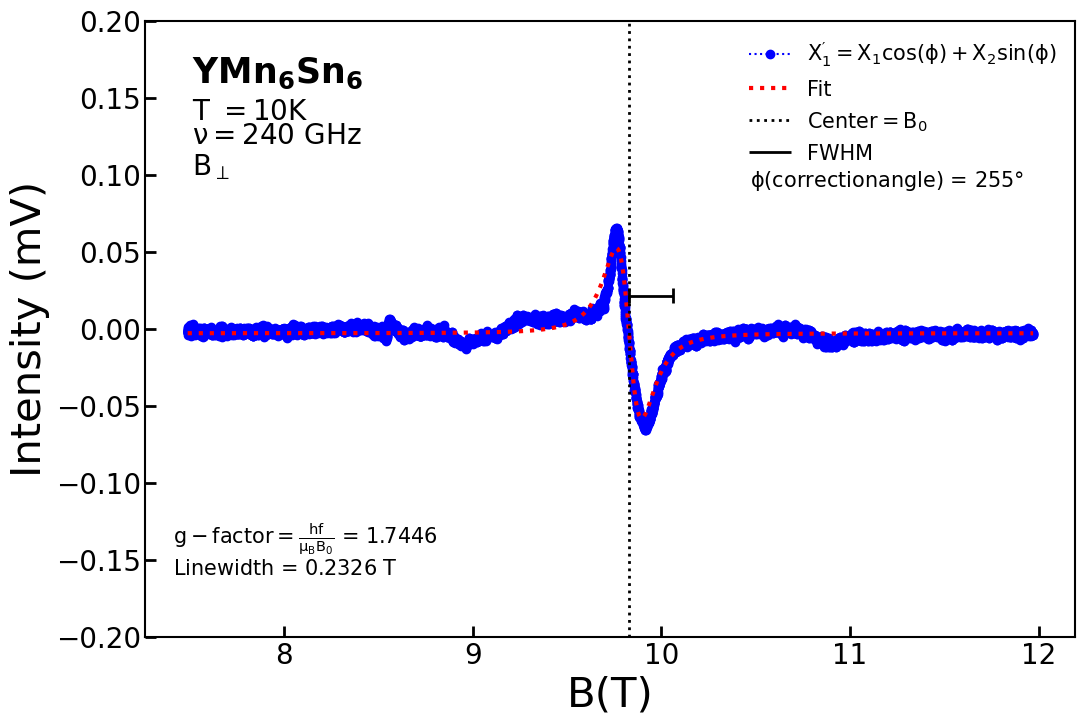

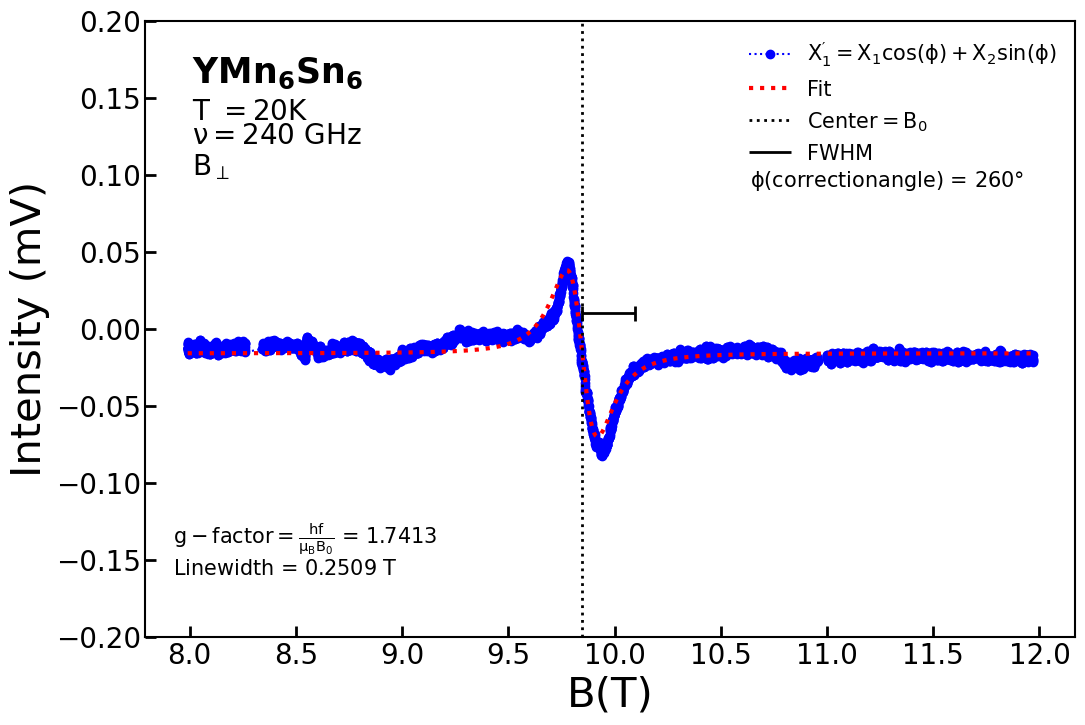

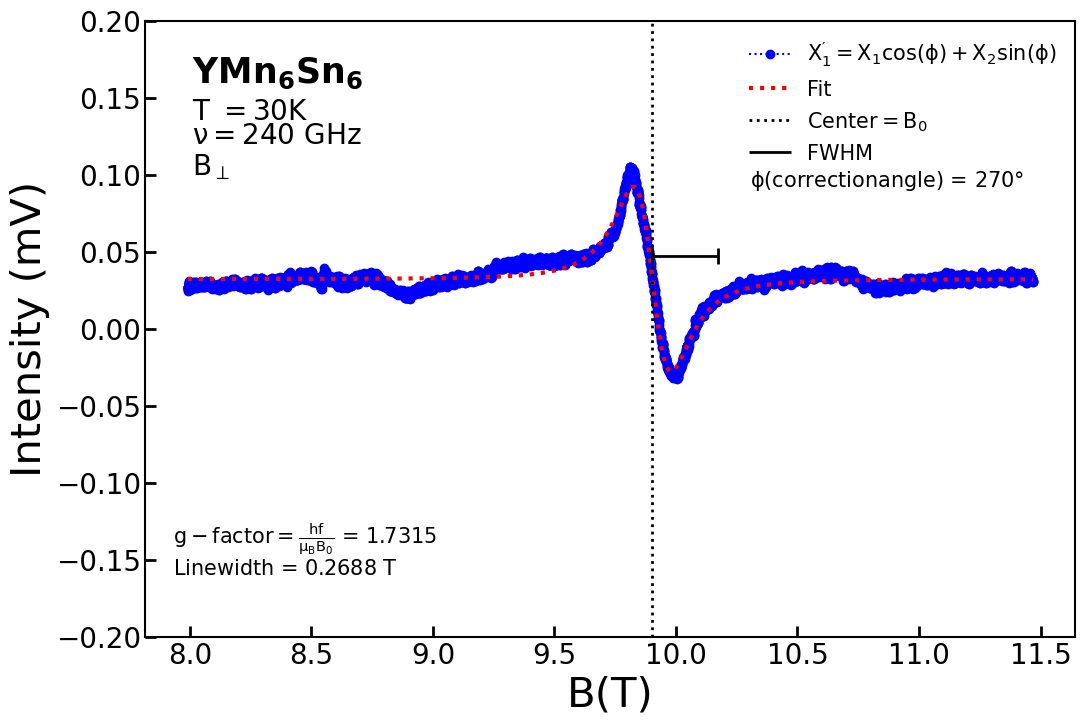

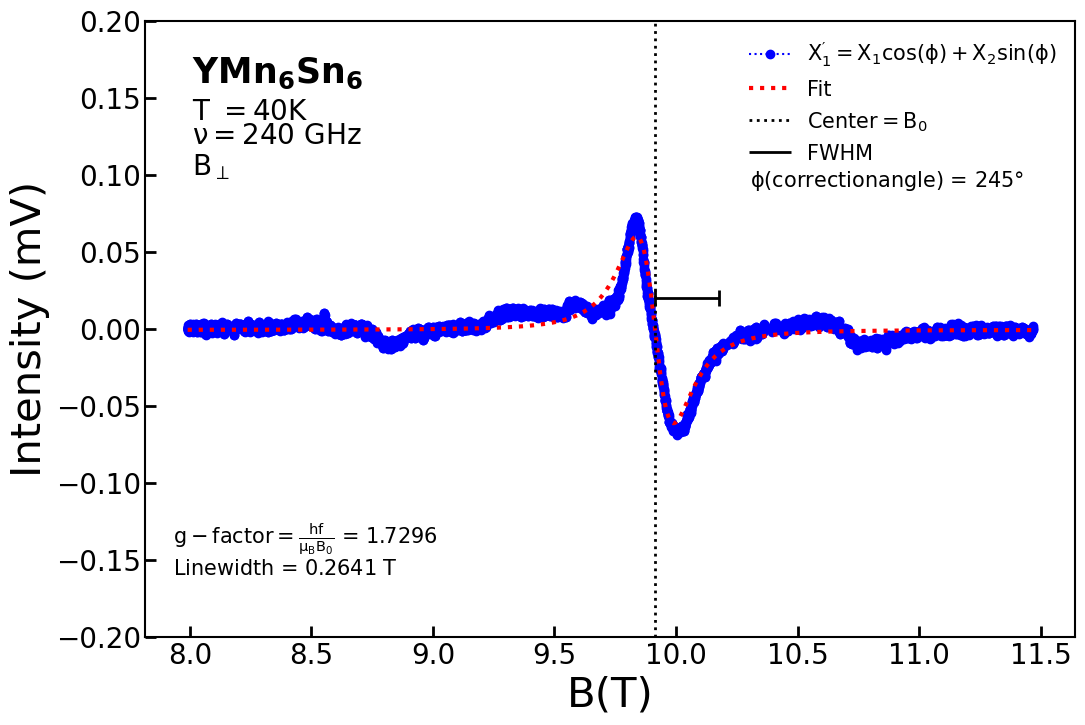

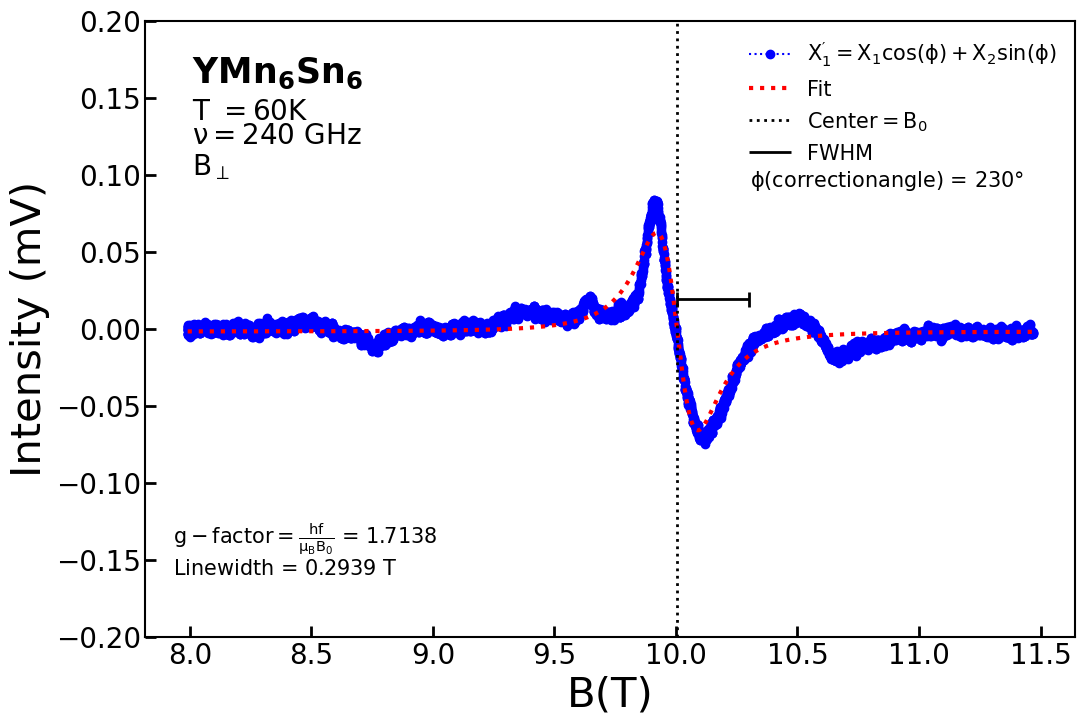

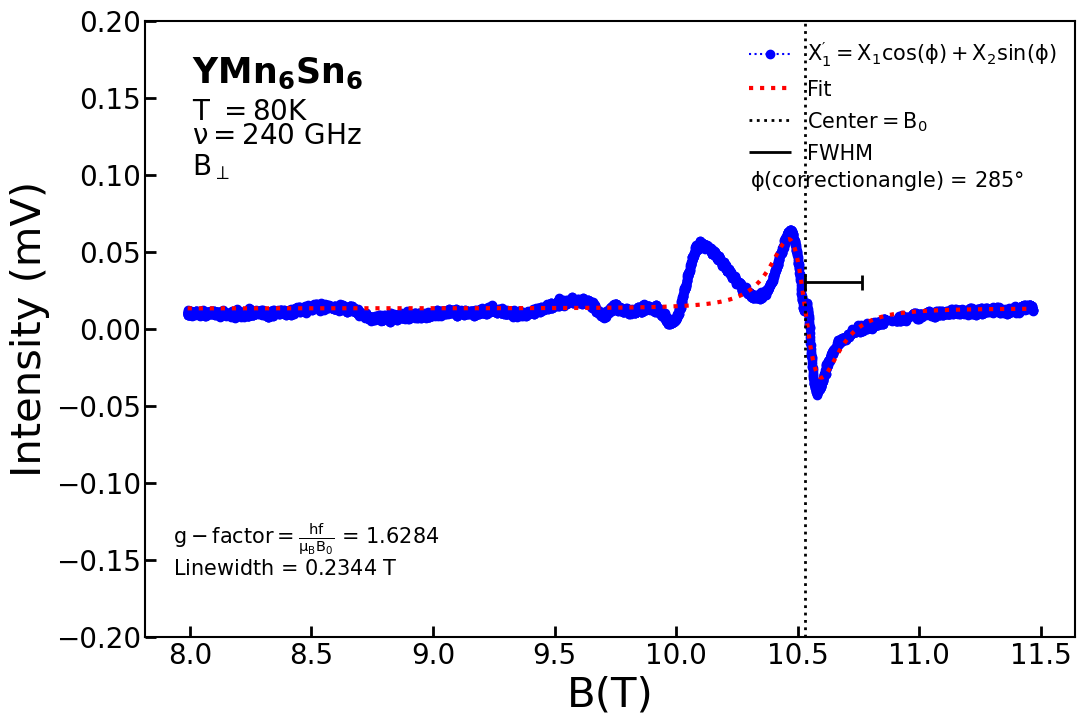

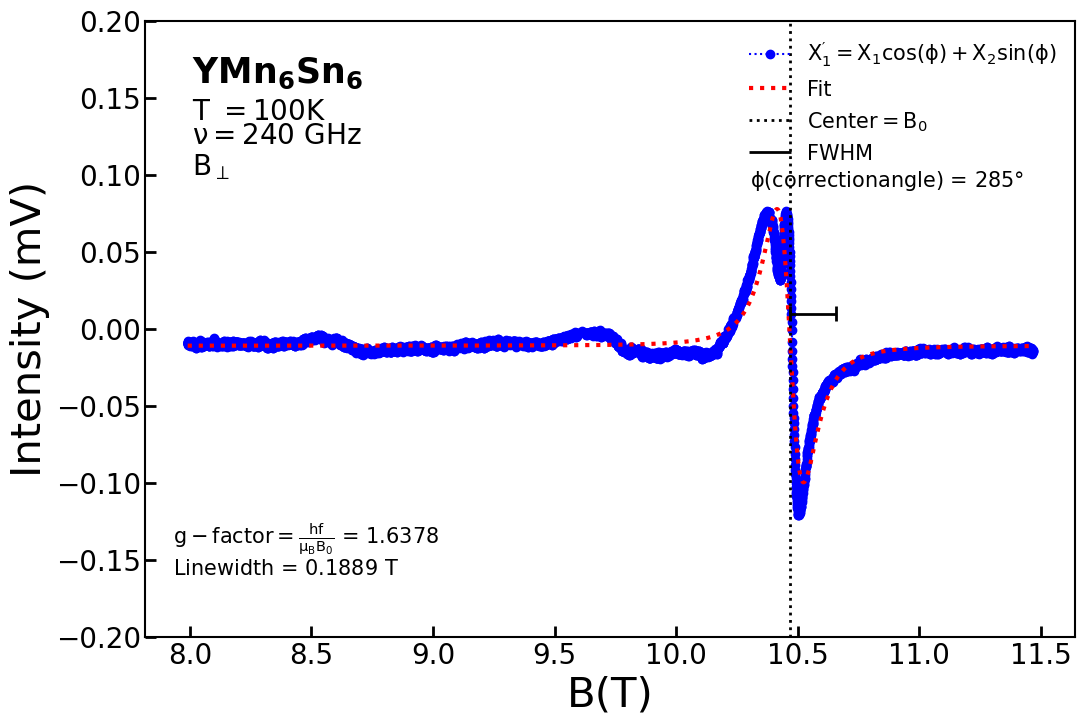

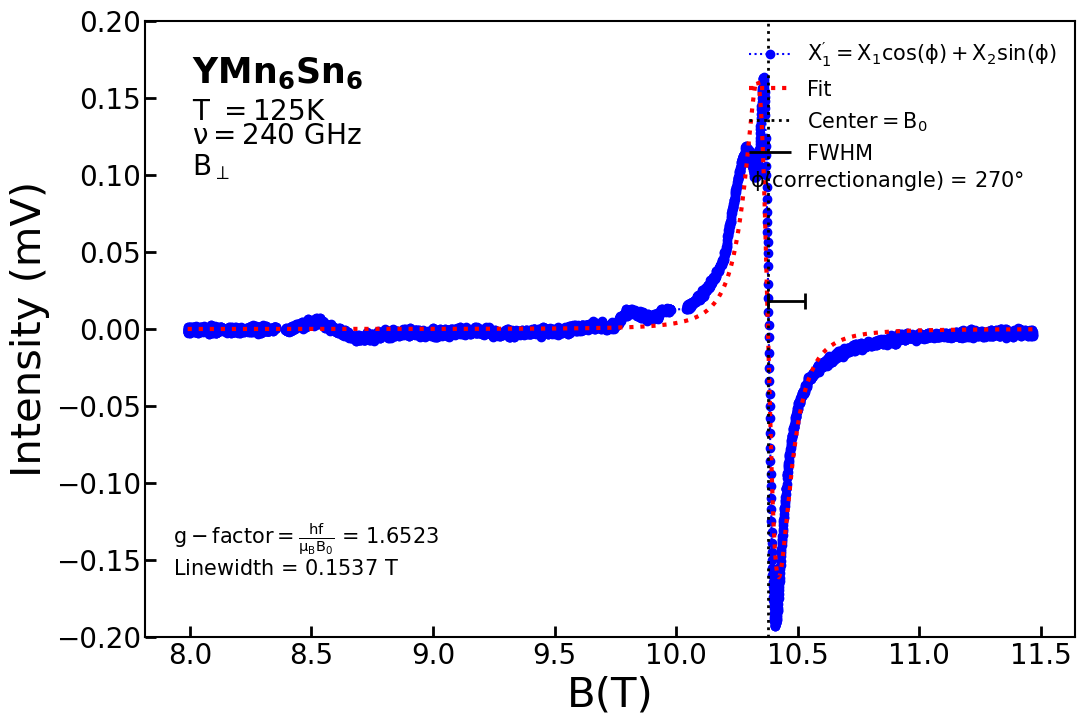

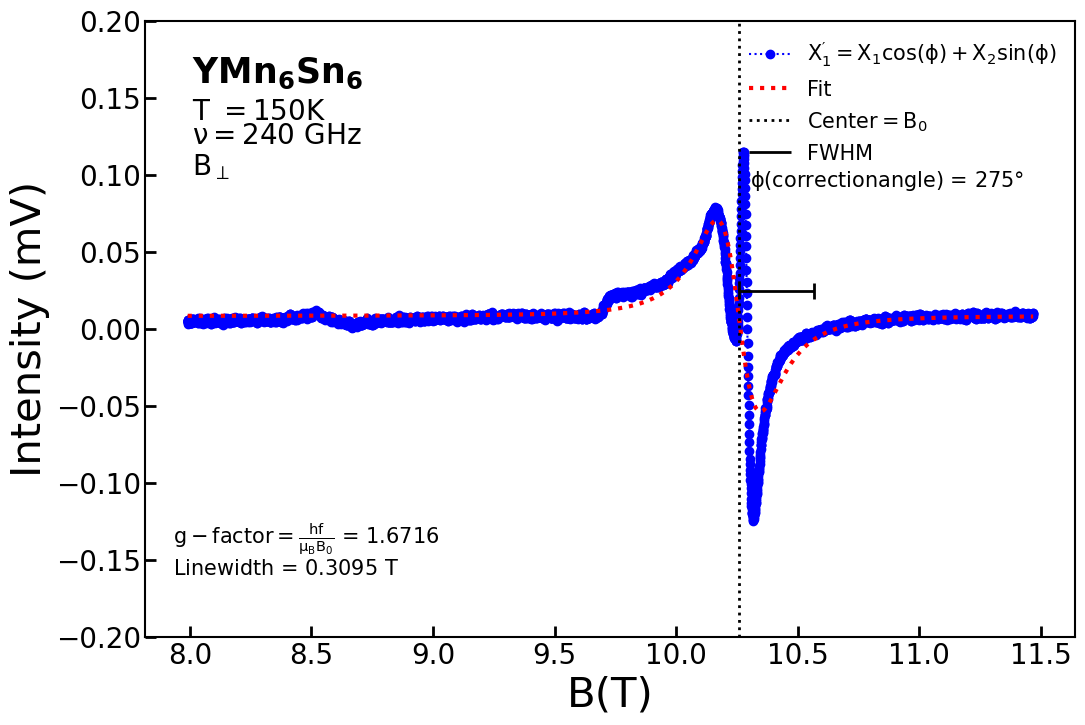

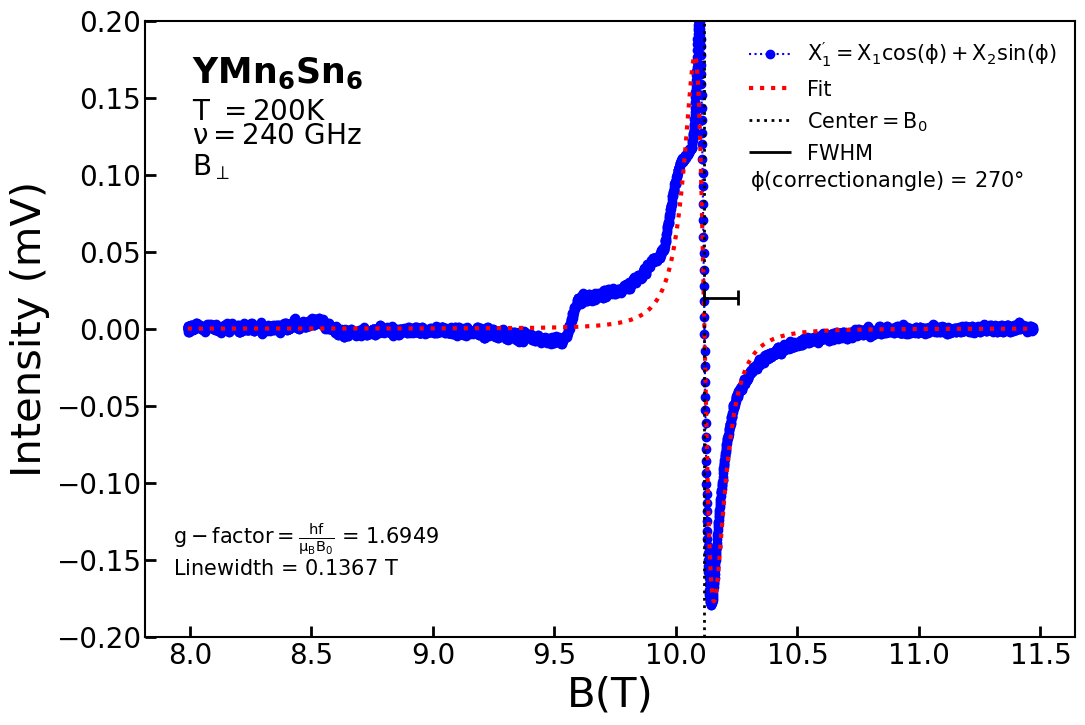

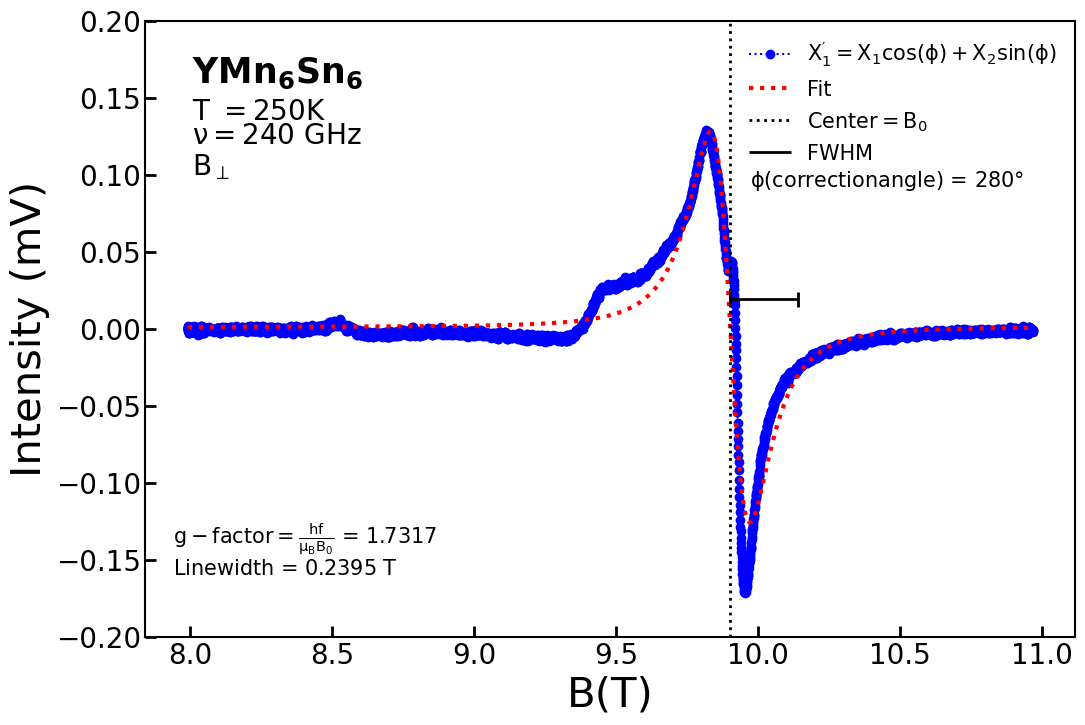

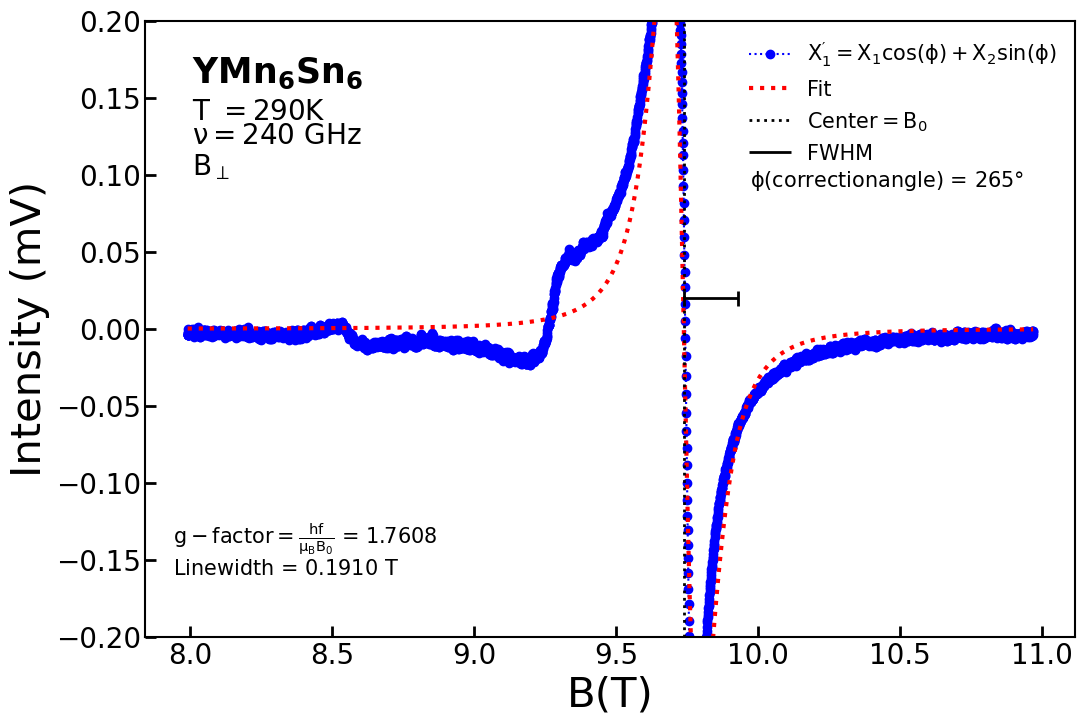

In [4]:
############## Create RAW data Figures For Each Temperature #####################
for i in datafiles:
    fig1,ax=plt.subplots()
    fig1.set_size_inches(12,8)
    fig1.subplots_adjust(hspace=.0)
    fig1.patch.set_facecolor('white')
    
    ax.plot(dict_data[i][0], dict_data[i][4], color="blue", linestyle="dotted", marker='o', label="$X_1'=X_1\cos(\phi)+X_2\sin(\phi)$")
    ax.plot(dict_data[i][5], dict_data[i][6], color="red", linestyle="dotted", linewidth=3, label="Fit")

    ax.annotate(r'$YMn_6Sn_6\ $',ha='left', xy=(0.05, 0.9),weight='bold',xycoords='axes fraction', fontsize=25)
    ax.annotate(r'$T\ = $'+str(dict_data[i][3]),ha='left', xy=(0.05, 0.84),xycoords='axes fraction', fontsize=20)
    ax.annotate(r'$\nu=240\ GHz$', ha='left', xy=(0.05, 0.8), xycoords='axes fraction', fontsize=20, color='black')
    ax.annotate(r'$B_\perp$',ha='left', xy=(0.05, 0.75),xycoords='axes fraction', fontsize=20)
    
    ax.annotate(r'$\phi (correction angle)$ = '+str(dict_data[i][9])+r'$\degree$',ha='left', xy=(0.65, 0.73),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$Linewidth$ = '+f"{dict_data[i][8]:.4f} T",ha='left', xy=(0.03,0.10),xycoords='axes fraction', fontsize=15)
    ax.annotate(r'$g-factor = \frac{hf}{\mu_BB_0}$ = '+f"{dict_data[i][7]:.4f}",ha='left', xy=(0.03,0.15),xycoords='axes fraction', fontsize=15)


    
    ax.vlines(x = dict_data[i][10],ymin=-0.2,ymax=0.2, color = 'black',linestyle="dotted",linewidth=2, label = '$Center=B_0$')
    ax.vlines(x = dict_data[i][10],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)
    ax.vlines(x = dict_data[i][10]+dict_data[i][8],ymin=dict_data[i][11]+0.015,ymax=dict_data[i][11]+0.025, color = 'black',linestyle="solid",linewidth=2)



    ax.hlines(y = dict_data[i][11]+0.02, xmin= dict_data[i][10], xmax=(dict_data[i][10]+dict_data[i][8]), linewidth=2, linestyle="solid", color='black', label='FWHM')




    
    
    ax.legend(loc='upper right', prop={'size': 15}, frameon=False)
    props = dict(boxstyle='round', facecolor='gray', alpha=0.5)
            
    #plt.title(label = r'$\mathrm{AgCrP_2S_6\ 240GHz\ EPR}$', fontsize = 32)
    ax.set_xlabel("B(T)", fontsize=30)
    ax.set_ylabel("Intensity (mV)",fontsize=30)
    ax.set_ylim(-0.2,0.2)
    ax.tick_params(axis='both', which='major', labelsize=20)
    #plt.savefig("YMnSn 240GHz_Perp ESR Fits "+i+".png", dpi=300)
    
    
    
    

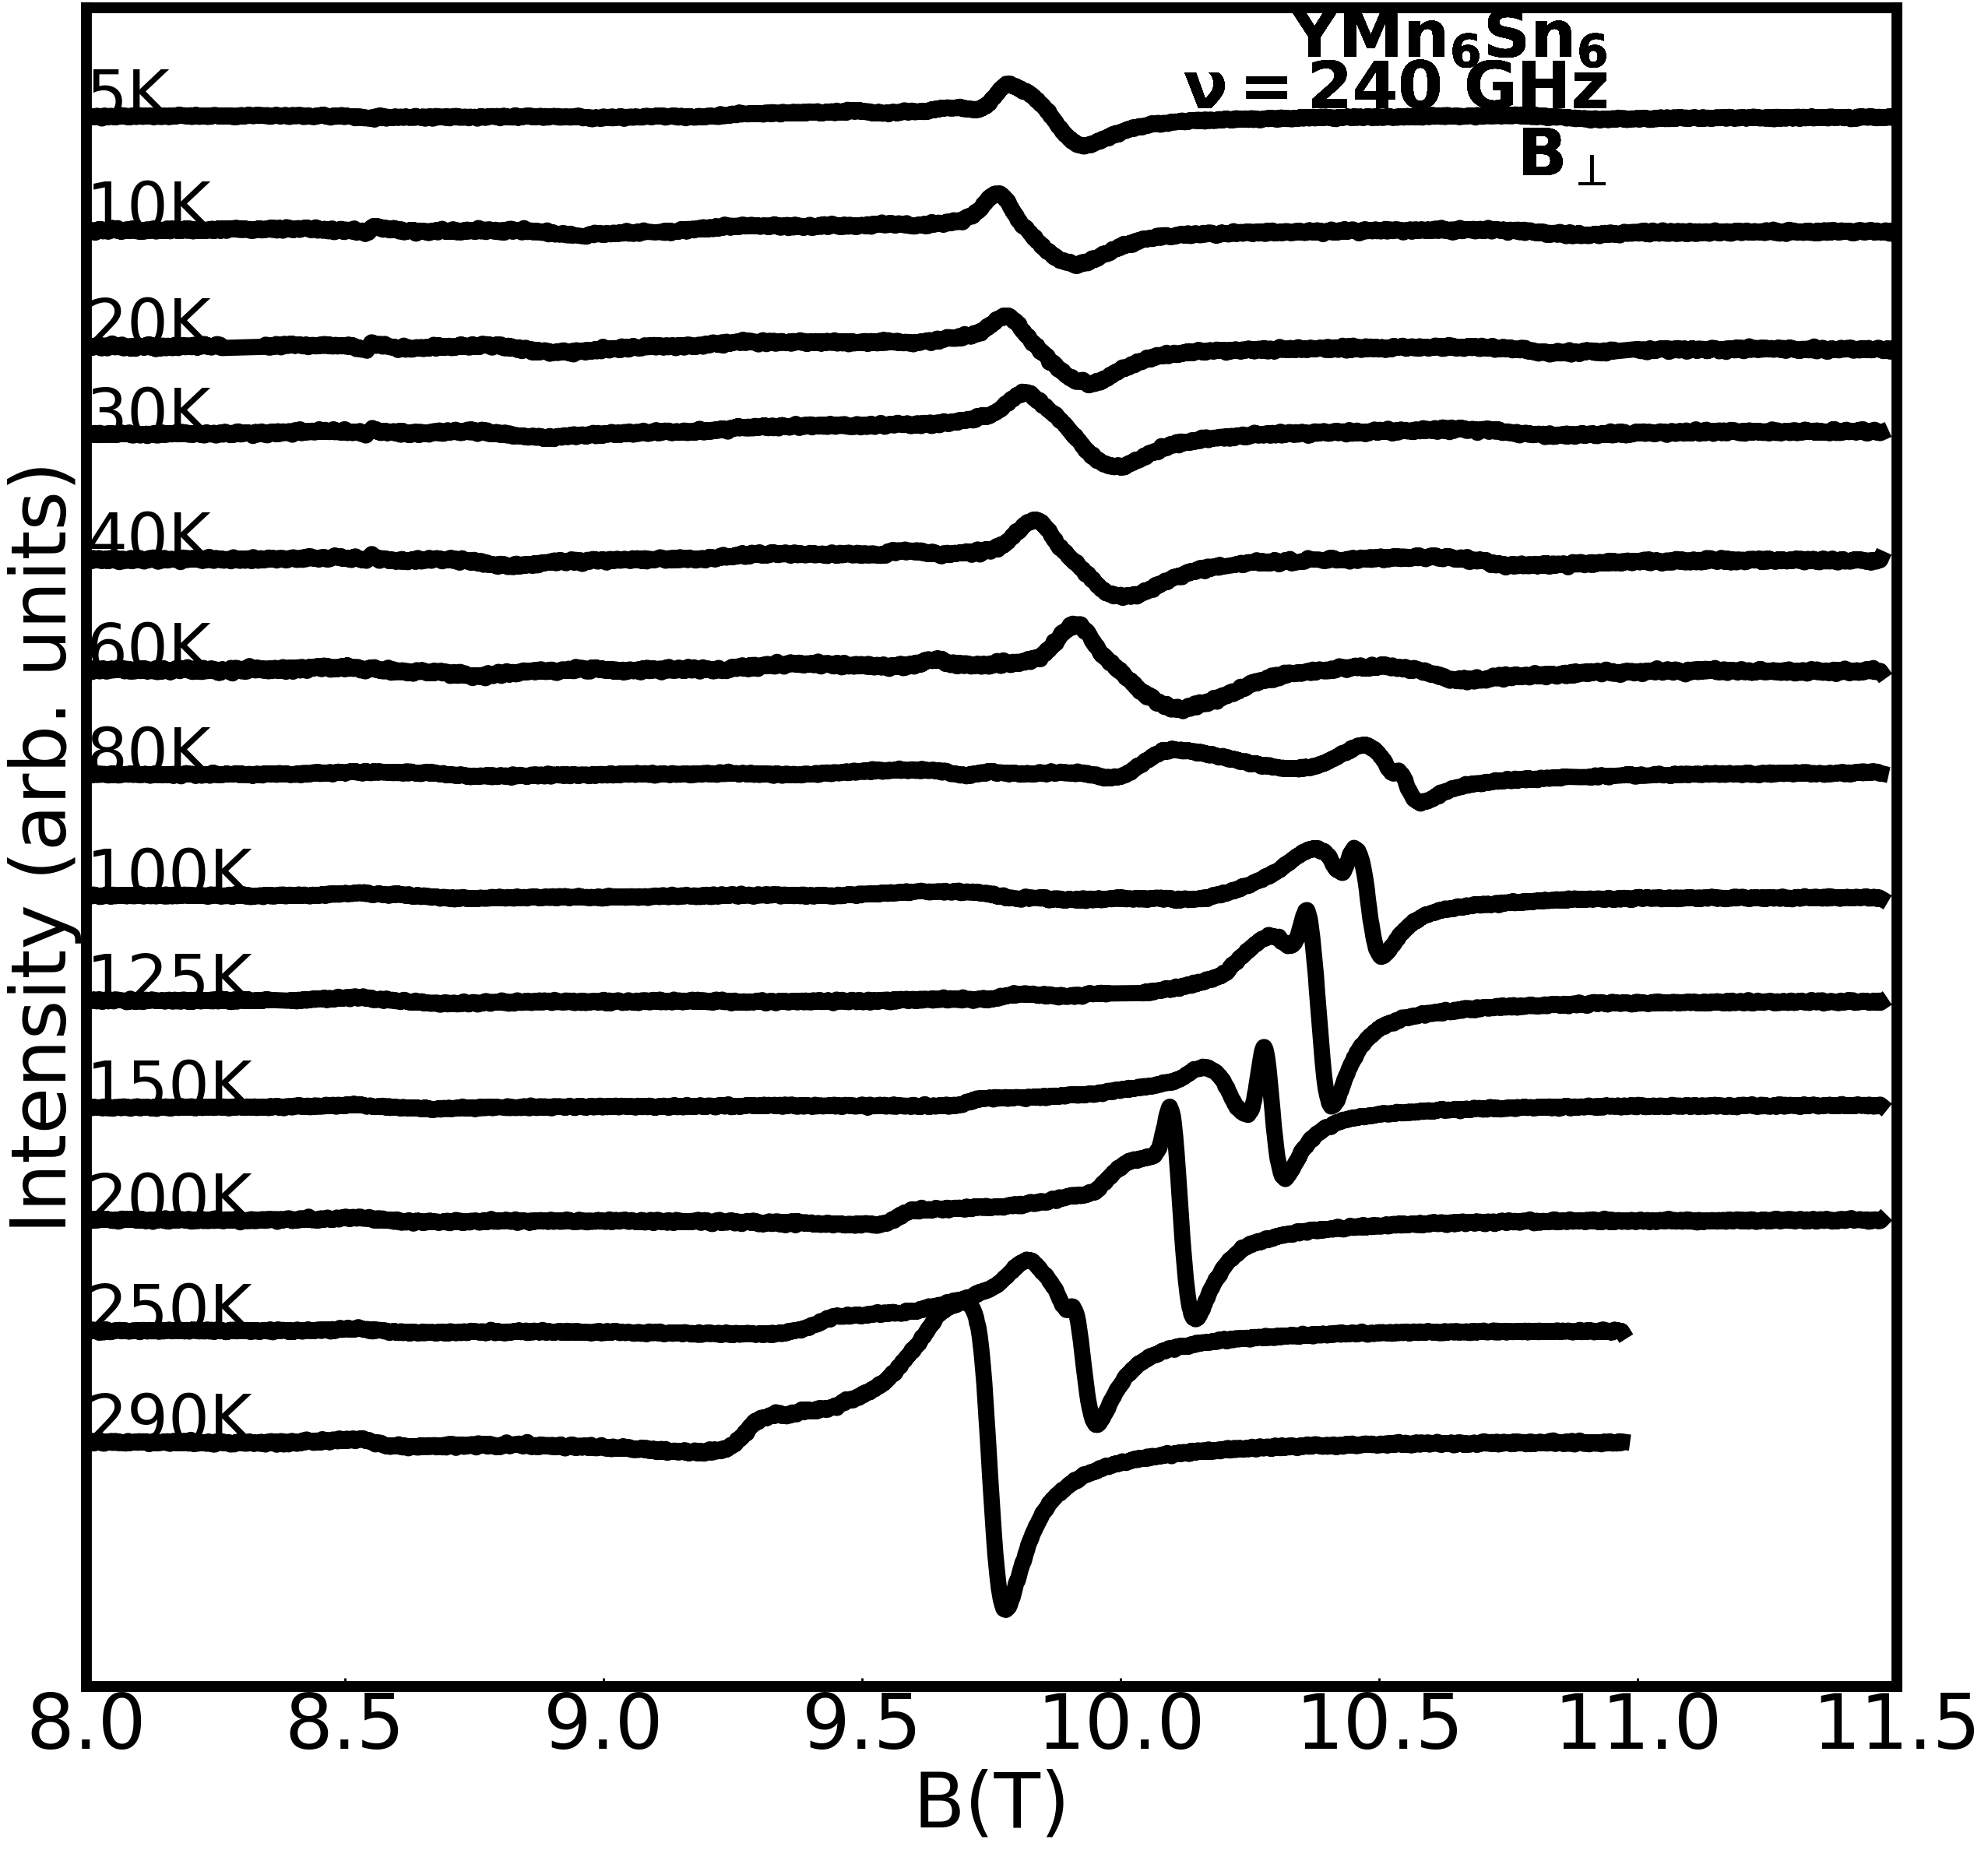

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
# Your existing code...
# Define temperatures for each dataset
temperatures = [5, 10, 20, 30, 40, 60, 80, 100, 125, 150, 200, 250,290]
# Define a custom colormap with grayscale gradient
custom_colors = [(i / (len(temperatures) - 1), 'black') for i in range(len(temperatures))] # Grayscale gradient
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', custom_colors)
# Plot data with gradient colors using the custom colormap
fig1, ax = plt.subplots()
fig1.set_size_inches(30, 28)
fig1.patch.set_facecolor('white') # White background
spacing = 0.20 # Adjust spacing between plots
for i, temperature in enumerate(temperatures):
    ax.plot(dict_data[datafiles[i]][0], dict_data[datafiles[i]][4] - 0.05 - spacing * i, color=custom_cmap(i / len(temperatures)), linestyle="solid", marker='o', markersize=1, linewidth=15)
    ax.annotate(f'{temperature}K', ha='left', xy=(8.0, dict_data[datafiles[i]][4][0] - 0.05 - spacing * i), xycoords='data', fontsize=60, color='black')
    ax.annotate(r'$YMn_6Sn_6$', ha='right', xy=(0.84, 0.97), weight='bold', xycoords='axes fraction', fontsize=60, color='black')
    ax.annotate(r'$\nu=240\ GHz$', ha='right', xy=(0.84, 0.94), weight='bold', xycoords='axes fraction', fontsize=60, color='black')
    ax.annotate(r'$B_\perp$',ha='right', xy=(0.84, 0.9), weight='bold', xycoords='axes fraction', fontsize=60, color='black')
    ax.set_facecolor('white') # White background
    props = dict(boxstyle='round', facecolor='gray', alpha=1.5)
    ax.set_xlabel("B(T)", fontsize=70, color='black')
    ax.set_ylabel("Intensity (arb. units)", fontsize=70, color='black')
    ax.set_xlim(8.0, 11.5)
    ax.tick_params(axis='both', which='major', labelsize=70, colors='black')

# Increase axis line thickness
ax.spines['bottom'].set_linewidth(10)  # X-axis
ax.spines['left'].set_linewidth(10)    # Y-axis
ax.spines['top'].set_linewidth(10)     # Top border (optional)
ax.spines['right'].set_linewidth(10)   # Right border (optional)

# Remove y-axis ticks and labels
ax.set_yticks([]) # This removes the y-axis ticks and labels
plt.savefig("YMnSn 240GHz_Perp Temperature Waterfall Plot 2.png", dpi=300, facecolor='white', bbox_inches='tight')
plt.show()

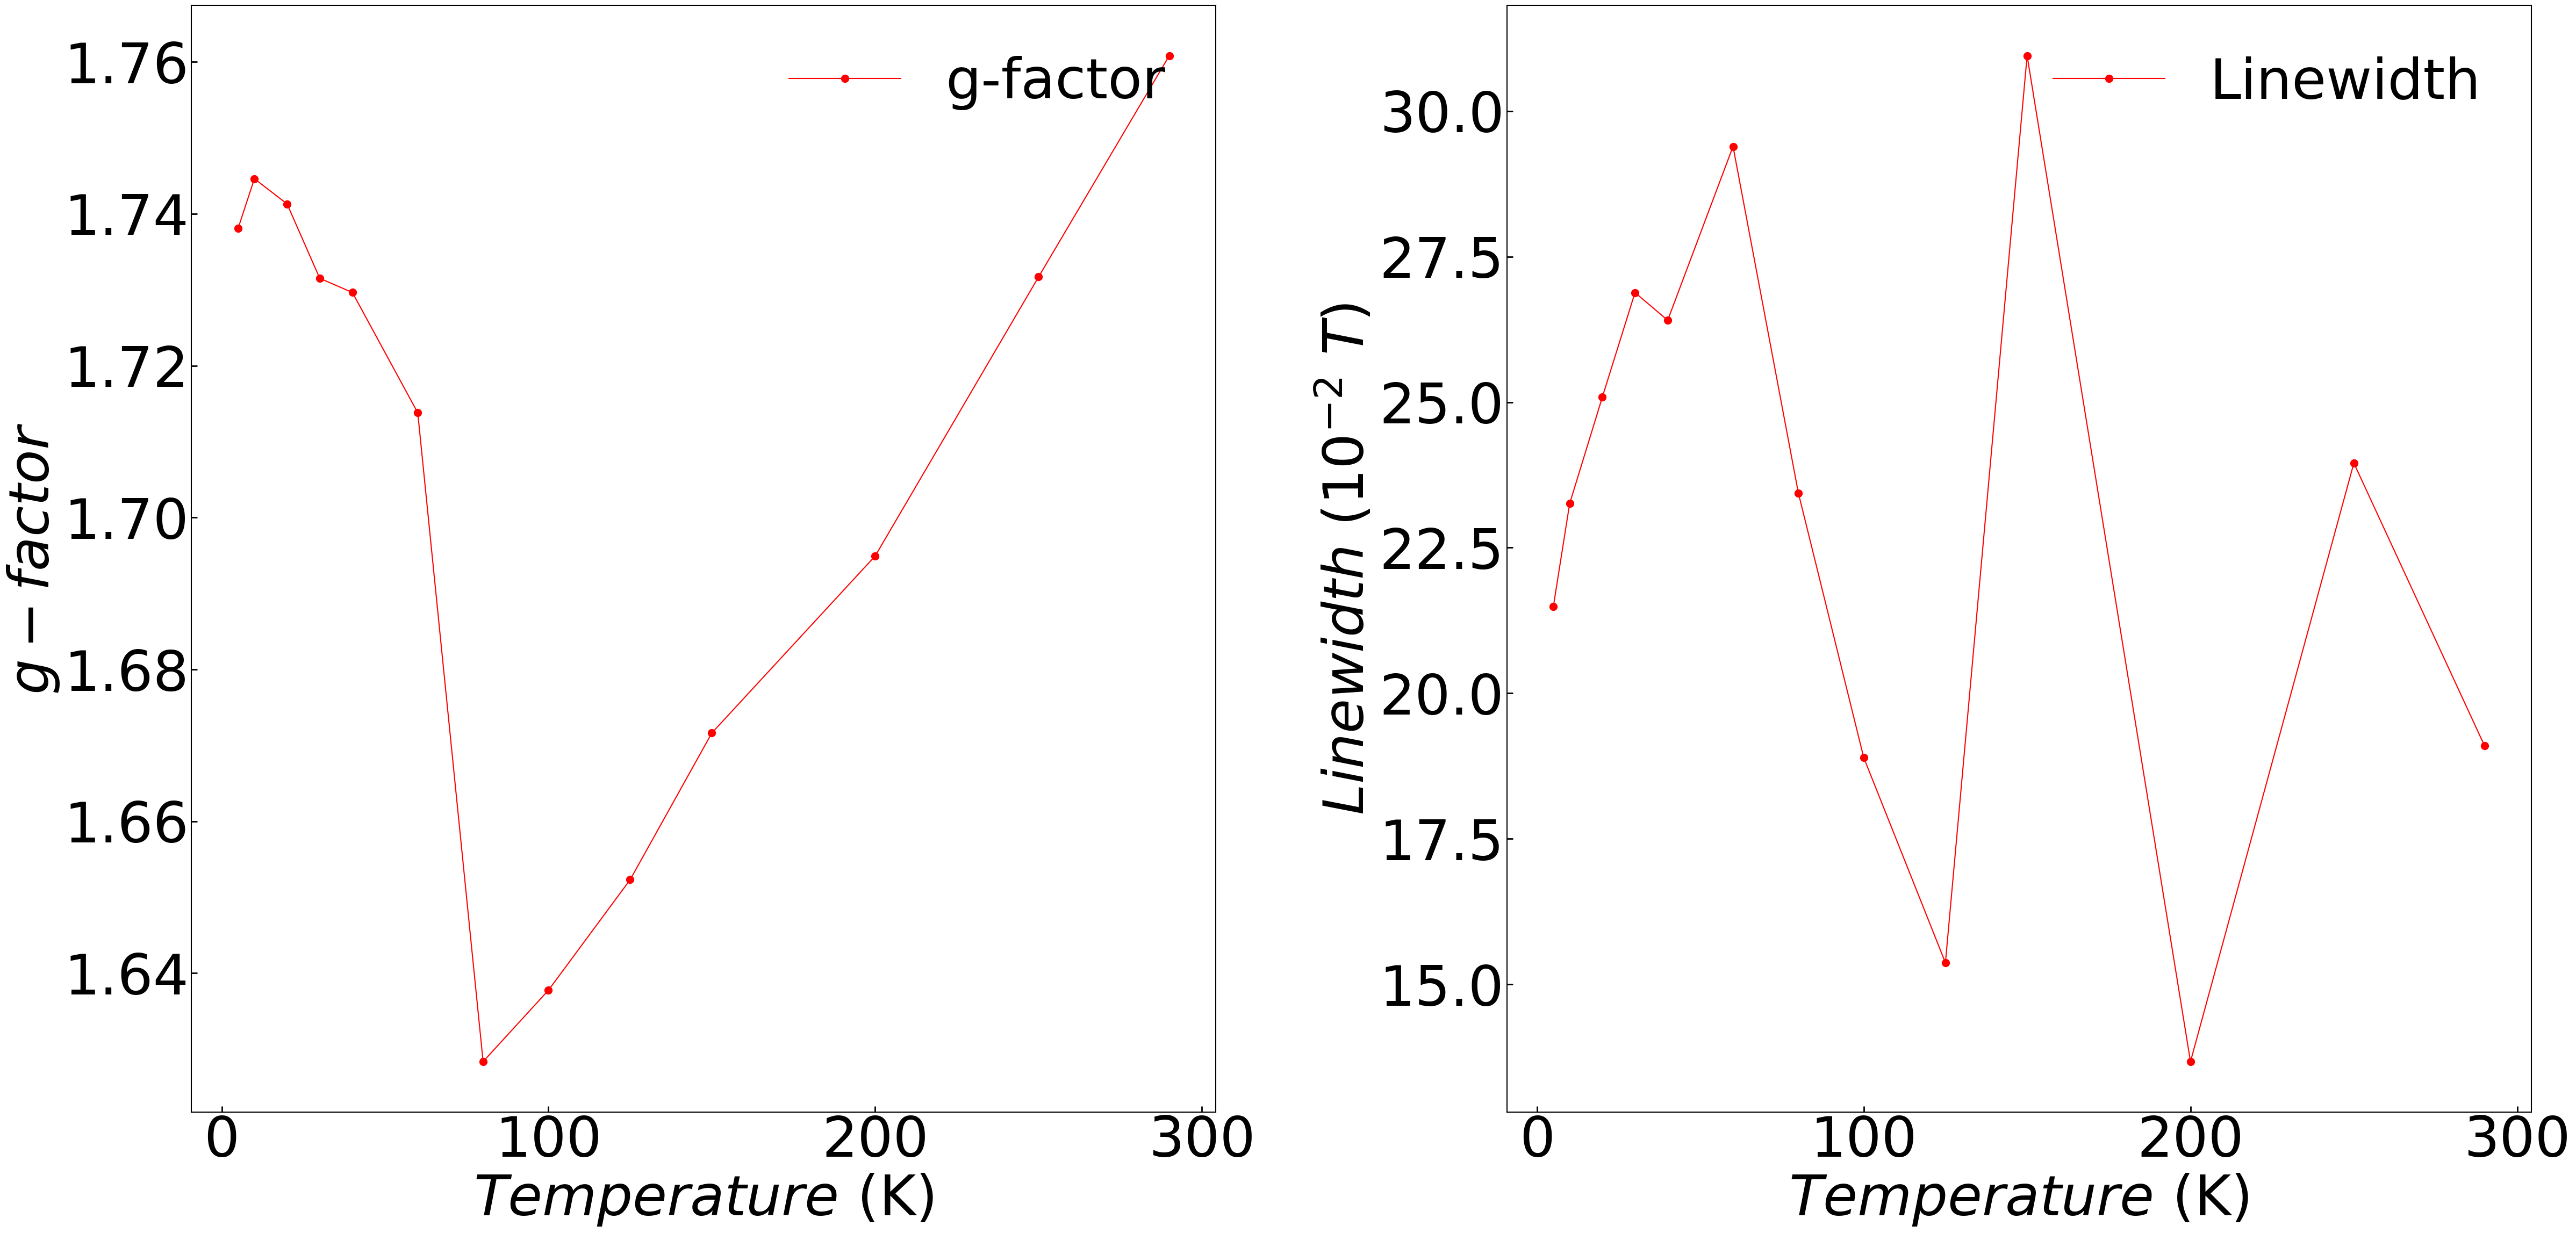

In [6]:
fig1, ((ax1,ax2)) = plt.subplots(1, 2)
fig1.subplots_adjust(hspace=.0)
fig1.patch.set_facecolor('white')
fig1.set_size_inches(50,25)

# ax2.set_title(Material,pad=18,fontsize=22)
ax1.set_xlabel(r'$\it{Temperature}\  $(K)', fontsize=75)
ax1.set_ylabel(r'$\it{g-factor}$', fontsize=75)

ax2.set_xlabel(r'$\it{Temperature}\  $(K)', fontsize=75)
ax2.set_ylabel(r'$\it{Linewidth}\ (10^{-2}\ T)$', fontsize=75)


# ax1.set_xlim(-0.2, 4)
# ax1.set_ylim(-0.08, 1.6)

#ax1.xaxis.set_major_locator(MultipleLocator(40))
#ax1.xaxis.set_minor_locator(MultipleLocator(10))
#ax1.yaxis.set_major_locator(MultipleLocator(0.01))
#ax1.yaxis.set_minor_locator(MultipleLocator(0.005))

#ax2.xaxis.set_major_locator(MultipleLocator(40))
#ax2.xaxis.set_minor_locator(MultipleLocator(10))
#ax2.yaxis.set_major_locator(MultipleLocator(1))
#ax2.yaxis.set_minor_locator(MultipleLocator(0.5))

ax1.plot(temps,gfactors,color='red',marker="o",markersize='10',markerfacecolor='Red',label="g-factor")

ax2.plot(temps,np.array(linewidths)*10**2,color='red',marker="o",markersize='10',markerfacecolor='Red',label="Linewidth")


ax1.legend(frameon=False,loc='upper right') , #bbox_to_anchor=(0.9,0.5)
ax2.legend(frameon=False,loc='upper right')




plt.tight_layout()
#plt.savefig("YMnSn 240GHz_Perp Parameter Plots.png")
plt.show()